# Yoochoose: Explore Dataset

In [1]:
%pylab inline
!mkdir -p exports

Populating the interactive namespace from numpy and matplotlib


## Table with features of train set

In [2]:
%spark

from utils import *
sc.addPyFile('utils.py')

train_sessions, test_sessions = load_sessions(sc)

In [3]:
print 'Train sessions:', train_sessions.count()
print 'Test sessions: ', test_sessions.count()

Train sessions: 9249729
Test sessions:  2312432


In [4]:
import collections

def extract_session_features((session_id, (clicks, buys))):
    start_time = min(ts for ts, _, _ in clicks)
    
    item_most_clicked = None
    item_clicks = collections.Counter()
    for ts, item_id, cat in clicks:
        item_clicks[item_id] += 1
        if item_clicks[item_id] > item_clicks[item_most_clicked]:
            item_most_clicked = item_id
    
    return Row(
        clicks=len(clicks),
        buys=len(buys),
        buyer=len(buys) > 0,
        clicked_items=len(set(item_id for ts, item_id, cat in clicks)),
        weekday=start_time.weekday(),
        hour_of_day=start_time.hour,
        day=start_time.strftime('%m/%d'),
        item_most_clicked=item_most_clicked,
    )

table_sessions = train_sessions.map(extract_session_features).toDF().toPandas()

In [5]:
table_sessions.head()

,buyer,buys,clicked_items,clicks,day,hour_of_day,item_most_clicked,weekday
0,False,0,1,3,05/23,18,214691537,4
1,False,0,5,8,04/21,16,214820392,0
2,False,0,4,4,04/24,10,214828959,3
3,False,0,1,1,08/27,12,214850949,2
4,True,1,3,3,08/29,1,214691338,4


In [6]:
sc.stop()

## Buying rate vs. time

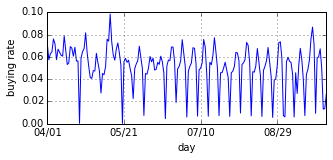

In [7]:
df_buyrate_day = table_sessions.groupby('day')['buyer'].mean()
df_buyrate_day.sort_index().plot(figsize=(5, 2), grid=True, linewidth=1)
ylabel('buying rate')
savefig('exports/dataset_buyrate_day.pdf', bbox_inches='tight')

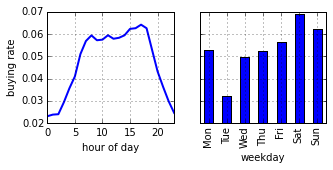

In [8]:
fig, axs = subplots(1, 2, figsize=(5, 2))

#fig.subplots_adjust(hspace=.01)
df_buyrate_hour = table_sessions.groupby('hour_of_day')['buyer'].mean()
df_buyrate_hour.sort_index().plot(ax=axs[0], grid=True, linewidth=2, ylim=(0.02, 0.07))
axs[0].set_ylabel('buying rate')
axs[0].set_xlabel('hour of day')

WEEKDAY_TO_NAME = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun',
}

df_buyrate_weekday = table_sessions.groupby('weekday')['buyer'].mean()
df_buyrate_weekday = df_buyrate_weekday.sort_index().reset_index()
df_buyrate_weekday['weekday'] = df_buyrate_weekday['weekday'].map(lambda n: WEEKDAY_TO_NAME[n])
df_buyrate_weekday = df_buyrate_weekday.set_index('weekday')
df_buyrate_weekday.plot(ax=axs[1], kind='bar', legend=False, ylim=(0.02, 0.07), grid=True, sharey=True)

savefig('exports/dataset_buyrate_hour_weekday.pdf', bbox_inches='tight')

## Buying rate vs. number of clicks and ItemID

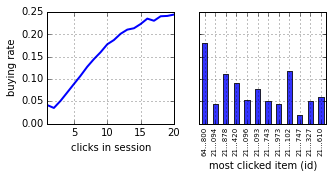

In [9]:
fig, axs = subplots(1, 2, figsize=(5, 2))

df_buyrate_clicks = table_sessions.query('0 < clicked_items <= 20').groupby('clicked_items')['buyer'].mean()
df_buyrate_clicks.sort_index().plot(ax=axs[0], linewidth=2)
axs[0].set_ylabel('buying rate')
axs[0].set_xlabel('clicks in session')
axs[0].grid(True)
axs[0].set_ylim((0.00, 0.25))

df_most_clicked = table_sessions.groupby('item_most_clicked')['buyer']\
    .agg(['mean', 'count'])\
    .sort('count', ascending=False)\
    .head(n=12)
df_most_clicked = df_most_clicked.reset_index()
df_most_clicked['item_most_clicked'] = df_most_clicked['item_most_clicked'].map(
    lambda s: s[:2] + '...' + s[-3:])
df_most_clicked = df_most_clicked.set_index('item_most_clicked')
df_most_clicked['mean'].plot(ax=axs[1], kind='bar', alpha=0.8, sharey=True)
axs[1].set_xlabel('most clicked item (id)')
axs[1].grid(True)
axs[1].set_ylim((0.00, 0.25))

for item in axs[1].get_xticklabels():
    item.set_fontsize(7)
    
fig.savefig('exports/dataset_buyrate_clicks_items.eps', bbox_inches='tight')
fig.savefig('exports/dataset_buyrate_clicks_items.pdf', bbox_inches='tight')